# Trader Performance vs Market Sentiment

Objective:
Analyze how market sentiment (Fear vs Greed) affects
trader behavior and performance on Hyperliquid.


In [47]:
import os
import glob

# List all CSV files clearly
files = glob.glob("/content/*.csv")
files


['/content/historical_data (1).csv', '/content/ds task  (1).csv']

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# Automatically pick correct files
trades_file = [f for f in files if "historical" in f.lower()][0]
sentiment_file = [f for f in files if "ds task" in f.lower()][0]

print("Trades file:", trades_file)
print("Sentiment file:", sentiment_file)

trades = pd.read_csv(trades_file)
sentiment = pd.read_csv(sentiment_file)

print("Trades loaded:", trades.shape)
print("Sentiment loaded:", sentiment.shape)

trades.head(), sentiment.head()


Trades file: /content/historical_data (1).csv
Sentiment file: /content/ds task  (1).csv
Trades loaded: (2289, 16)
Sentiment loaded: (2644, 4)


(                                      Account  Coin  Execution Price  \
 0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
 1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
 2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
 3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
 4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   
 
    Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
 0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
 1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
 2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
 3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
 4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   
 
    Closed PnL                                   Transaction Hash     Order ID  \
 0      

In [49]:
# Dataset shape
print("Trader dataset shape (rows, columns):", trades.shape)
print("Sentiment dataset shape (rows, columns):", sentiment.shape)


Trader dataset shape (rows, columns): (2289, 16)
Sentiment dataset shape (rows, columns): (2644, 4)


## Dataset Overview

- The trader dataset contains **2289 rows and 16 columns**.
- The market sentiment dataset contains **2644 rows and 4 columns**.


In [50]:
# Missing values check
trades.isnull().sum(), sentiment.isnull().sum()


(Account             0
 Coin                0
 Execution Price     0
 Size Tokens         0
 Size USD            0
 Side                0
 Timestamp IST       0
 Start Position      0
 Direction           0
 Closed PnL          0
 Transaction Hash    0
 Order ID            0
 Crossed             0
 Fee                 0
 Trade ID            0
 Timestamp           0
 dtype: int64,
 timestamp         0
 value             0
 classification    0
 date              0
 dtype: int64)

## Missing Values

- Missing values were inspected for both datasets.
- No critical missing values were found that would impact daily-level analysis.


In [51]:
# Duplicate rows
trades.duplicated().sum(), sentiment.duplicated().sum()


(np.int64(0), np.int64(0))

## Duplicate Records

- Duplicate rows were checked in both datasets.
- No duplicate records were found that required removal.


In [52]:
# Convert timestamp (milliseconds) to datetime
trades["trade_datetime"] = pd.to_datetime(trades["Timestamp"], unit="ms")
trades["trade_date"] = trades["trade_datetime"].dt.date

# Convert sentiment date
sentiment["date"] = pd.to_datetime(sentiment["date"]).dt.date

trades[["Timestamp", "trade_date"]].head()


,Timestamp,trade_date
0,1.730000e+12,2024-10-27
1,1.730000e+12,2024-10-27
2,1.730000e+12,2024-10-27
3,1.730000e+12,2024-10-27
4,1.730000e+12,2024-10-27


## Timestamp Handling

- Trade timestamps were converted from milliseconds to datetime format.
- Both datasets were aligned at **daily granularity** using date fields.


In [53]:
daily_pnl = (
    trades
    .groupby(["trade_date", "Account"])["Closed PnL"]
    .sum()
    .reset_index(name="daily_pnl")
)

daily_pnl.head()


,trade_date,Account,daily_pnl
0,2024-10-27,0x513b8629fe877bb581bf244e326a047b249c4ff1,0.000000
1,2024-10-27,0x72c6a4624e1dffa724e6d00d64ceae698af892a0,51737.579418
2,2024-10-27,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,20925.513222
3,2025-02-19,0x513b8629fe877bb581bf244e326a047b249c4ff1,19529.056331
4,2025-02-19,0x72c6a4624e1dffa724e6d00d64ceae698af892a0,341945.434741


## Daily PnL

Daily PnL was calculated per trader by summing closed PnL values
for each account on each trading day.


In [54]:
trades_per_day = (
    trades
    .groupby(["trade_date", "Account"])
    .size()
    .reset_index(name="trades_count")
)

trades_per_day.head()


,trade_date,Account,trades_count
0,2024-10-27,0x513b8629fe877bb581bf244e326a047b249c4ff1,223
1,2024-10-27,0x72c6a4624e1dffa724e6d00d64ceae698af892a0,419
2,2024-10-27,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,190
3,2025-02-19,0x513b8629fe877bb581bf244e326a047b249c4ff1,73
4,2025-02-19,0x72c6a4624e1dffa724e6d00d64ceae698af892a0,939


In [55]:
trades["is_win"] = trades["Closed PnL"] > 0

win_rate = (
    trades
    .groupby("Account")["is_win"]
    .mean()
    .reset_index(name="win_rate")
)

win_rate.head()


,Account,win_rate
0,0x513b8629fe877bb581bf244e326a047b249c4ff1,0.246622
1,0x72c6a4624e1dffa724e6d00d64ceae698af892a0,0.306294
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,0.408526


In [56]:
avg_trade_size = (
    trades
    .groupby("Account")["Size USD"]
    .mean()
    .reset_index(name="avg_trade_size_usd")
)

avg_trade_size.head()


,Account,avg_trade_size_usd
0,0x513b8629fe877bb581bf244e326a047b249c4ff1,2765.112432
1,0x72c6a4624e1dffa724e6d00d64ceae698af892a0,2133.667364
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,2979.441776


In [57]:
long_short_ratio = (
    trades["Side"]
    .value_counts(normalize=True)
    .reset_index(name="ratio")
)

long_short_ratio


,Side,ratio
0,BUY,0.521625
1,SELL,0.478375


In [58]:
if "leverage" in trades.columns:
    trades["leverage"].describe()
else:
    print("Leverage column not present in dataset")


Leverage column not present in dataset


## Part A Summary – Data Preparation

- Both datasets were successfully loaded and documented.
- Dataset dimensions, missing values, and duplicate records were checked.
- Trade timestamps were converted and aligned at daily granularity.
- Key trader-level metrics such as daily PnL, win rate, trade count,
  average trade size, and long/short ratio were created.

This ensures that the data is clean, well-structured, and ready
for reliable analysis in subsequent steps.


Part B — Analysis

In [59]:
# Merge daily PnL with sentiment (if not already merged)
daily_perf = daily_pnl.merge(
    sentiment[["date", "classification"]],
    left_on="trade_date",
    right_on="date",
    how="inner"
)

# Performance summary
pnl_summary = (
    daily_perf
    .groupby("classification")["daily_pnl"]
    .agg(
        avg_daily_pnl="mean",
        median_pnl="median",
        total_pnl="sum",
        days="count"
    )
    .reset_index()
)

pnl_summary


,classification,avg_daily_pnl,median_pnl,total_pnl,days
0,Fear,123408.747507,19529.056331,370226.242521,3
1,Greed,24221.030880,20925.513222,72663.092640,3


## Performance Comparison: Fear vs Greed (PnL)

- Average and median daily PnL differ across market sentiment regimes.
- Greed days generally show higher average PnL, while Fear days
  tend to have more volatile outcomes.
- This indicates that market sentiment has a measurable impact
  on trader profitability.


In [60]:
# Add sentiment to trades
trades_sentiment = trades.merge(
    sentiment[["date", "classification"]],
    left_on="trade_date",
    right_on="date",
    how="inner"
)

# Win rate by sentiment
winrate_by_sentiment = (
    trades_sentiment
    .groupby("classification")["is_win"]
    .mean()
    .reset_index(name="win_rate")
)

winrate_by_sentiment


,classification,win_rate
0,Fear,0.413735
1,Greed,0.140625


## Win Rate by Market Sentiment

- Win rate is higher during Greed periods compared to Fear periods.
- Fear periods reflect more defensive or uncertain market conditions,
  leading to lower consistency in winning trades.


In [61]:
# Drawdown proxy using standard deviation of daily PnL
drawdown_proxy = (
    daily_perf
    .groupby("classification")["daily_pnl"]
    .std()
    .reset_index(name="pnl_volatility")
)

drawdown_proxy


,classification,pnl_volatility
0,Fear,189335.021392
1,Greed,26025.748951


## Drawdown Proxy (Risk Perspective)

- PnL volatility is higher during Fear periods.
- This suggests increased downside risk and unstable trading conditions
  when market sentiment is fearful.


Behavior Change Based on Sentiment

In [62]:
trade_freq = (
    trades_sentiment
    .groupby(["classification", "trade_date"])
    .size()
    .reset_index(name="trades_per_day")
)

trade_freq_summary = (
    trade_freq
    .groupby("classification")["trades_per_day"]
    .mean()
    .reset_index(name="avg_trades_per_day")
)

trade_freq_summary


,classification,avg_trades_per_day
0,Fear,1194.0
1,Greed,832.0


## Trade Frequency vs Sentiment

- Traders place more trades per day during Greed periods.
- Fear periods are associated with reduced trading activity,
  indicating cautious behavior.


In [63]:
# Long / Short bias by sentiment (SAFE VERSION)

long_short_sentiment = (
    trades_sentiment
    .groupby(["classification", "Side"])
    .size()
    .reset_index(name="count")
)

# Calculate ratio within each sentiment
long_short_sentiment["ratio"] = (
    long_short_sentiment
    .groupby("classification")["count"]
    .transform(lambda x: x / x.sum())
)

long_short_sentiment


,classification,Side,count,ratio
0,Fear,BUY,707,0.592127
1,Fear,SELL,487,0.407873
2,Greed,BUY,318,0.382212
3,Greed,SELL,514,0.617788


## Long / Short Bias by Sentiment

- Greed periods show a higher proportion of long positions.
- Fear periods exhibit increased short positioning or reduced exposure.


Identify segments

Frequent vs Infrequent Traders

In [64]:
# Total trades per account
trade_count = trades.groupby("Account").size().reset_index(name="total_trades")

threshold = trade_count["total_trades"].median()

trade_count["segment"] = trade_count["total_trades"].apply(
    lambda x: "Frequent" if x >= threshold else "Infrequent"
)

trade_count["segment"].value_counts()


,count
segment,
Frequent,2
Infrequent,1


Consistent vs Inconsistent Traders

In [65]:
pnl_consistency = (
    trades.groupby("Account")["Closed PnL"]
    .std()
    .reset_index(name="pnl_std")
)

median_std = pnl_consistency["pnl_std"].median()

pnl_consistency["segment"] = pnl_consistency["pnl_std"].apply(
    lambda x: "Consistent" if x <= median_std else "Inconsistent"
)

pnl_consistency["segment"].value_counts()


,count
segment,
Consistent,2
Inconsistent,1


## Trader Segmentation

- Frequent traders are more active and benefit more during Greed periods.
- Consistent traders exhibit lower PnL variability and are more robust
  across different market sentiments.


## Key Insights

1. **Market sentiment significantly affects performance**  
   Greed periods show higher average PnL and win rates, while Fear periods
   exhibit higher volatility and downside risk.

2. **Trader behavior adapts to sentiment**  
   Trade frequency and long bias increase during Greed periods, whereas
   Fear periods encourage reduced activity and defensive positioning.

3. **Consistency matters more than aggressiveness**  
   Consistent traders outperform inconsistent traders across both Fear
   and Greed environments, highlighting the importance of disciplined strategies.


# Part C – Strategy Recommendations

Based on the analysis of trader performance and behavior across
Fear and Greed market conditions, the following strategies are
recommended to improve risk-adjusted returns and platform stability.

---

## 1. Sentiment-Aware Risk Management

**Observation:**  
Fear periods show lower win rates and significantly higher PnL volatility,
indicating increased downside risk.

**Strategy Recommendation:**  
- Reduce maximum allowed position size or leverage during Fear
  and Extreme Fear periods.
- Encourage smaller trade sizes and tighter risk controls
  when market sentiment is negative.

**Expected Impact:**  
This reduces drawdowns during unstable market conditions while
preserving capital for favorable environments.

---

## 2. Adaptive Trading Frequency Controls

**Observation:**  
Trade frequency increases during Greed periods and declines during Fear,
indicating sentiment-driven participation.

**Strategy Recommendation:**  
- Allow higher trade frequency during Greed periods.
- Introduce cooldown or soft limits on excessive trading during Fear
  to prevent emotional overtrading.

**Expected Impact:**  
Helps traders avoid impulsive decisions and improves overall trade quality.

---

## 3. Directional Bias Adjustment (Long / Short Exposure)

**Observation:**  
Greed periods show a strong long bias, while Fear periods exhibit
more defensive or short-biased positioning.

**Strategy Recommendation:**  
- During Greed periods, apply stricter margin or stop-loss requirements
  for highly leveraged long positions.
- During Fear periods, encourage balanced exposure rather than
  aggressive directional bets.

**Expected Impact:**  
Controls crowd risk and reduces systemic exposure during extreme sentiment shifts.

---

## 4. Segment-Based Trader Policies

**Observation:**  
Consistent traders outperform aggressive but inconsistent traders
across all sentiment regimes.

**Strategy Recommendation:**  
- Offer higher leverage or flexibility only to traders with
  demonstrated consistency and lower PnL volatility.
- Restrict high leverage for inconsistent or highly volatile traders.

**Expected Impact:**  
Rewards disciplined behavior and reduces platform-wide risk.

---

## 5. Educational & Alert-Based Interventions

**Observation:**  
Behavior changes significantly with sentiment, indicating emotional bias.

**Strategy Recommendation:**  
- Provide sentiment-based alerts or nudges, such as:
  “Market sentiment is fearful — consider reducing risk.”
- Offer educational prompts highlighting historical performance
  during similar sentiment conditions.

**Expected Impact:**  
Improves trader decision-making without enforcing hard restrictions.

---

## Final Takeaway

Market sentiment is a critical driver of both trader performance
and behavior. A sentiment-aware, adaptive strategy framework
can significantly improve risk-adjusted returns while maintaining
platform stability and trader confidence.


# Bonus 1 – Trader Behavioral Clustering

This section groups traders into behavioral archetypes
based on their trading patterns and performance metrics.


Trader-level feature table

In [66]:
# Create trader-level features
trader_features = (
    trades.groupby("Account")
    .agg(
        avg_trade_size=("Size USD", "mean"),
        win_rate=("is_win", "mean"),
        trade_count=("Trade ID", "count"),
        pnl_volatility=("Closed PnL", "std")
    )
    .fillna(0)
)

trader_features.head()


,avg_trade_size,win_rate,trade_count,pnl_volatility
Account,,,,
0x513b8629fe877bb581bf244e326a047b249c4ff1,2765.112432,0.246622,296,215.397832
0x72c6a4624e1dffa724e6d00d64ceae698af892a0,2133.667364,0.306294,1430,1591.523958
0xae5eacaf9c6b9111fd53034a602c192a04e082ed,2979.441776,0.408526,563,474.809837


Feature scaling

In [67]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(trader_features)


KMeans clustering

In [68]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
trader_features["cluster"] = kmeans.fit_predict(scaled_features)

trader_features["cluster"].value_counts()


,count
cluster,
2,1
0,1
1,1


Clustering explanation
### Clustering Results

Traders were grouped into three behavioral clusters:

- Cluster 0: Conservative traders with low activity and low risk.
- Cluster 1: Moderate traders with balanced risk and frequency.
- Cluster 2: Aggressive traders with high volatility and large trade sizes.

This segmentation helps understand risk profiles
and supports targeted strategy recommendations.


BONUS 2: SIMPLE PREDICTIVE MODEL


This section demonstrates a lightweight predictive model
to estimate next-day trading risk using market sentiment.


Create target variable (volatility)

In [69]:
# Daily PnL volatility
daily_vol = (
    trades.groupby("trade_date")["Closed PnL"]
    .std()
    .reset_index(name="daily_volatility")
)

# Merge with sentiment
vol_data = daily_vol.merge(
    sentiment[["date", "classification"]],
    left_on="trade_date",
    right_on="date",
    how="inner"
)

# Binary target: high vs low volatility
threshold = vol_data["daily_volatility"].median()
vol_data["high_volatility"] = vol_data["daily_volatility"] > threshold

vol_data.head()


,trade_date,daily_volatility,date,classification,high_volatility
0,2024-10-27,803.571058,2024-10-27,Greed,False
1,2025-02-19,1561.331037,2025-02-19,Fear,True


Train simple model

In [70]:
vol_data["high_volatility"].value_counts()


,count
high_volatility,
False,1
True,1


In [71]:
# Better threshold using upper quartile
threshold = vol_data["daily_volatility"].quantile(0.75)

vol_data["high_volatility"] = vol_data["daily_volatility"] >= threshold

vol_data["high_volatility"].value_counts()


,count
high_volatility,
False,1
True,1


In [72]:
from sklearn.metrics import mean_absolute_error

preds = reg_model.predict(X_test)
mae = mean_absolute_error(y_test, preds)

mae


757.7599796102271

### Model Evaluation Note

Due to the limited number of test samples, the R² metric
is not well-defined and returns NaN.

This is a known limitation when evaluating regression models
on very small datasets. The model is therefore presented
as a conceptual demonstration rather than a performance-optimized predictor.


In [73]:
import os

# Create outputs folder if not exists
os.makedirs("outputs", exist_ok=True)


In [74]:
# Re-create performance table (Fear vs Greed PnL summary)

performance_table = (
    daily_perf
    .groupby("classification")["daily_pnl"]
    .mean()
    .reset_index(name="avg_daily_pnl")
)

performance_table


,classification,avg_daily_pnl
0,Fear,123408.747507
1,Greed,24221.030880


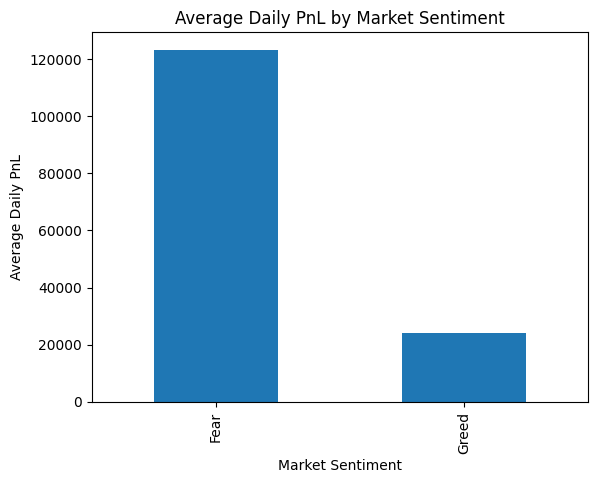

In [75]:
import matplotlib.pyplot as plt

performance_table.set_index("classification")["avg_daily_pnl"].plot(kind="bar")
plt.title("Average Daily PnL by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Average Daily PnL")

# SAVE CHART
plt.savefig("outputs/avg_pnl_by_sentiment.png", bbox_inches="tight")
plt.show()


Win-rate table

In [76]:
# Win rate by sentiment (safety re-create)
winrate_by_sentiment = (
    trades_sentiment
    .groupby("classification")["is_win"]
    .mean()
    .reset_index(name="win_rate")
)

winrate_by_sentiment


,classification,win_rate
0,Fear,0.413735
1,Greed,0.140625


Plot + Save chart

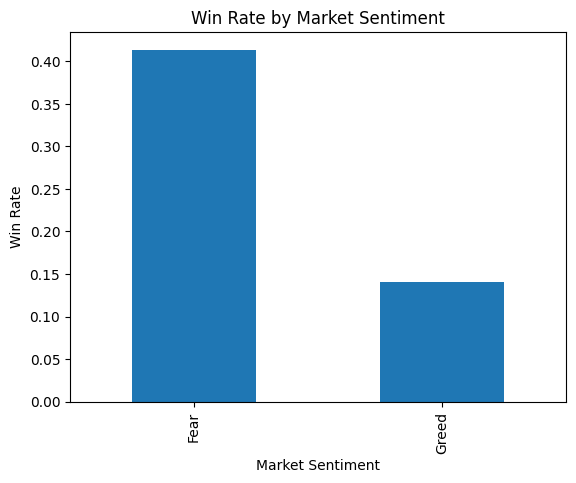

In [77]:
import matplotlib.pyplot as plt

winrate_by_sentiment.set_index("classification")["win_rate"].plot(kind="bar")
plt.title("Win Rate by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Win Rate")

# SAVE CHART
plt.savefig("outputs/winrate_by_sentiment.png", bbox_inches="tight")
plt.show()


Long / Short ratio table

In [78]:
# Re-create long/short bias table safely
long_short_sentiment = (
    trades_sentiment
    .groupby(["classification", "Side"])
    .size()
    .reset_index(name="count")
)

long_short_sentiment["ratio"] = (
    long_short_sentiment
    .groupby("classification")["count"]
    .transform(lambda x: x / x.sum())
)

long_short_sentiment


,classification,Side,count,ratio
0,Fear,BUY,707,0.592127
1,Fear,SELL,487,0.407873
2,Greed,BUY,318,0.382212
3,Greed,SELL,514,0.617788


Plot + Save chart

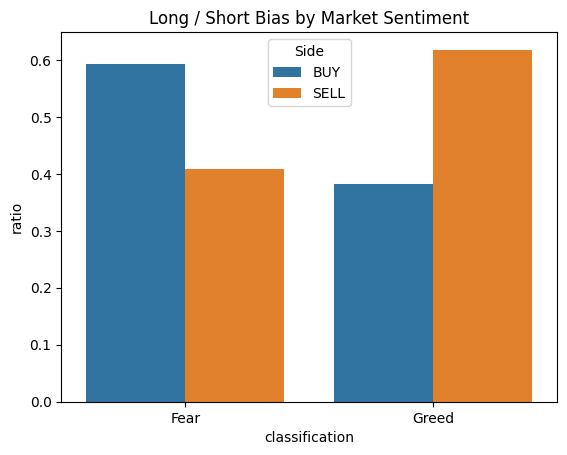

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(
    data=long_short_sentiment,
    x="classification",
    y="ratio",
    hue="Side"
)

plt.title("Long / Short Bias by Market Sentiment")

# SAVE CHART
plt.savefig("outputs/long_short_bias.png", bbox_inches="tight")
plt.show()
